# Systematic Equity Trading using Machine Learning

## Machine Learning Engineer Nanodegree - Capstone Project

In this project, we explore the US equity fundamentals database, hosted at [usfundamentals.com](http://www.usfundamentals.com), to see if we can use unsupervised and supervised learning techniques to predict equity prices.  We attempt to find similarities using common financial ratios across all companies in the dataset to see if any persistent anomalies can be discovered.  We will be using 5 years of quaterly data, which is originally retrieved from the individual companies public filings with the SEC.  The data is supplemented with additional data linking the individual companies in the database with historical prices retrieved from publicly available sources (Yahoo Finance and Google Finance); this is done by first retrieving trading tickers by querying Edgar and then using the associated tickers as required.

## Getting Started

We start by importing important modules, defining functions needed to retrieve the trading tickers and preparing the final database for exploration.

In [672]:
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
import seaborn as sns
from pandas.io import data, wb
import sys
import datetime
import matplotlib.pyplot as plt
from textwrap import wrap
#from tqdm import tqdm
%matplotlib inline

We define some functions to query the website using their API, the database can also be downloaded by first registering with the website.

In [487]:
#Everyone must use their own access token as per the use agreement (this is free):
fundamentalsAccessToken = '7uD00n7eLJH8O2pk7jMVUg'
#When this variable is True, the code will attempt to refresh all queries.  Otherwise it will ignore the calls.
globalUpdate = False

In [664]:
def getIndicatorByCategory(inputCategory=None, inputCompanies=None, inputFrequency='q', perType='yq'):
    #This function returns the data for a specific category.
    #Returns all values when input category and companies are None.  Othewise, can submit a list of values.
    if inputCategory is None:
        if inputCompanies is None:
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?frequency=' + inputFrequency + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
        else:
            if np.shape(inputCompanies) == ():
                inputCompanies = [inputCompanies]
            inputCompanies = np.array(map(str, map(int, inputCompanies)))
            inputCompanies = ",".join(inputCompanies)
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?companies=' + inputCompanies + '&frequency=' + inputFrequency + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
    else:
        if np.shape(inputCategory) == ():
            inputCategory = [inputCategory]
        inputCategory = ",".join(inputCategory)
        if inputCompanies is None:
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?frequency=' + inputFrequency + '&indicators=' + inputCategory + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
        else:
            if np.shape(inputCompanies) == ():
                inputCompanies = [inputCompanies]
            inputCompanies = np.array(map(str, map(int, inputCompanies)))
            inputCompanies = ",".join(inputCompanies)
            print('https://api.usfundamentals.com/v1/indicators/xbrl?companies=' + inputCompanies + '&frequency=' + inputFrequency + '&indicators=' + inputCategory + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?companies=' + inputCompanies + '&frequency=' + inputFrequency + '&indicators=' + inputCategory + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)

def getCompanyMeta(inputCompanies=None):
    #This function retrieves a full company list and their reporting name history
    if inputCompanies is None:
        return pd.read_csv('https://api.usfundamentals.com/v1/companies/xbrl?format=csv&token=' + fundamentalsAccessToken)
    else:
        if np.shape(inputCompanies) == ():
            inputCompanies = [inputCompanies]
        inputCompanies = np.array(map(str, map(int, inputCompanies)))
        inputCompanies = ",".join(inputCompanies)
        #print 'https://api.usfundamentals.com/v1/companies/xbrl?companies=' + inputCompanies + '&token=' + fundamentalsAccessToken
        return pd.read_csv('https://api.usfundamentals.com/v1/companies/xbrl?companies=' + inputCompanies + '&format=csv&token=' + fundamentalsAccessToken)
        
def getIndicatorMeta(inputCategory=None, inputFrequency='q', perType='yq'):
    #Use this function to retrieve information on all indicators
    if inputCategory is None:
        return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl/meta?frequency=' + inputFrequency + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
    else:
        if np.shape(inputCategory) == ():
            inputCategory = [inputCategory]
        inputCategory = ",".join(inputCategory)
        return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl/meta?frequency=' + inputFrequency + '&indicators=' + inputCategory + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)

def formatIndicatorString(inputString):
    #Returns the indicator label separated by word
    return reduce(lambda x,y: x+y, map(lambda x,y: y+x, inputString, map(lambda x:' ' if x==x.upper() else '', inputString)))[1:]

## Data Exploration

We now go start exploring the data set, starting with the number of companies and then the number of features and corresponding time span.

In [943]:
if globalUpdate:
    allCompanies = getCompanyMeta()
display(allCompanies.head())
companies = pd.DataFrame(allCompanies.iloc[:, 1:].values, allCompanies.iloc[:, 0].values, columns=allCompanies.iloc[:, 1:].columns)
#See the transformed results for a quick comparison as a check
companies.sort_index(inplace=True)
display(companies.loc[allCompanies.iloc[:, 0].head().values])
display(companies.describe())

,company_id,name_latest,names_previous
0,1000045,Nicholas Financial Inc,NaN
1,1000180,Sandisk Corp,NaN
2,1000209,Medallion Financial Corp,NaN
3,1000228,Henry Schein Inc,NaN
4,1000229,Core Laboratories N V,NaN


,name_latest,names_previous
1000045,Nicholas Financial Inc,NaN
1000180,Sandisk Corp,NaN
1000209,Medallion Financial Corp,NaN
1000228,Henry Schein Inc,NaN
1000229,Core Laboratories N V,NaN


,name_latest,names_previous
count,12183,2066
unique,12156,2065
top,United Community Bancorp,Windstream Corp
freq,2,2


In total, we have 12,170 companies in the sample.  We can now start looking in to the dataset to see what type of features are available and whether or not the database is complete.

In [489]:
#Retrieve all possible features that we can use from the database.
if globalUpdate:
    allLabels = getIndicatorMeta(inputFrequency='q', perType='yq')
display(allLabels.head())
display(allLabels.describe())
display(pd.DataFrame(allLabels.gt(0).sum().ix[1:], columns=['Total Values by Year']))
display(pd.DataFrame(allLabels.sum(axis=1), columns=['Total Values by Feature']).describe())

,Indicator ID,Total,2010,2011,2012,2013,2014,2015,2016
0,LiabilitiesAndStockholdersEquity,400542,75,16720,25727,26650,26590,25775,11977
1,Assets,400020,78,16695,25753,26609,26557,25717,11931
2,CashAndCashEquivalentsAtCarryingValue,362583,79,15282,23267,23895,24024,23445,10869
3,StockholdersEquity,360468,67,14513,23166,24127,24076,23412,10795
4,NetIncomeLoss,352293,72,14418,22418,23322,23487,22984,10730


,Total,2010,2011,2012,2013,2014,2015,2016
count,8515.000000,8515.000000,8515.000000,8515.000000,8515.000000,8515.000000,8515.000000,8515.000000
mean,4177.116148,0.700528,136.486671,258.101468,286.505696,290.082678,286.123782,134.371227
std,20516.019673,4.788704,821.846476,1299.514926,1376.918816,1386.037667,1357.353569,634.108327
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.000000,0.000000,0.000000,2.000000,3.000000,3.000000,2.000000,1.000000
50%,336.000000,0.000000,6.000000,16.000000,20.000000,21.000000,21.000000,10.000000
75%,1558.500000,0.000000,38.000000,94.000000,104.000000,106.000000,107.000000,51.000000
max,400542.000000,79.000000,16720.000000,25753.000000,26650.000000,26590.000000,25775.000000,11977.000000


,Total Values by Year
Total,8515
2010,940
2011,5992
2012,7043
2013,7342
2014,7244
2015,6951
2016,6549


,Total Values by Feature
count,8515.000000
mean,5569.488197
std,27354.692898
min,4.000000
25%,88.000000
50%,448.000000
75%,2078.000000
max,534056.000000


Based on the results, we can see that there are a total of 8515 separate features, however, not all of them are reported by all companies.  Furthermore, the data for 2010 is incomplete as there are only 940 datapoints greater than 0; this year should be dropped.  We need to now decide how many features to keep.  To do this, we can plot the total submissions by feature, sorted from highest to lowest (for the Total column):

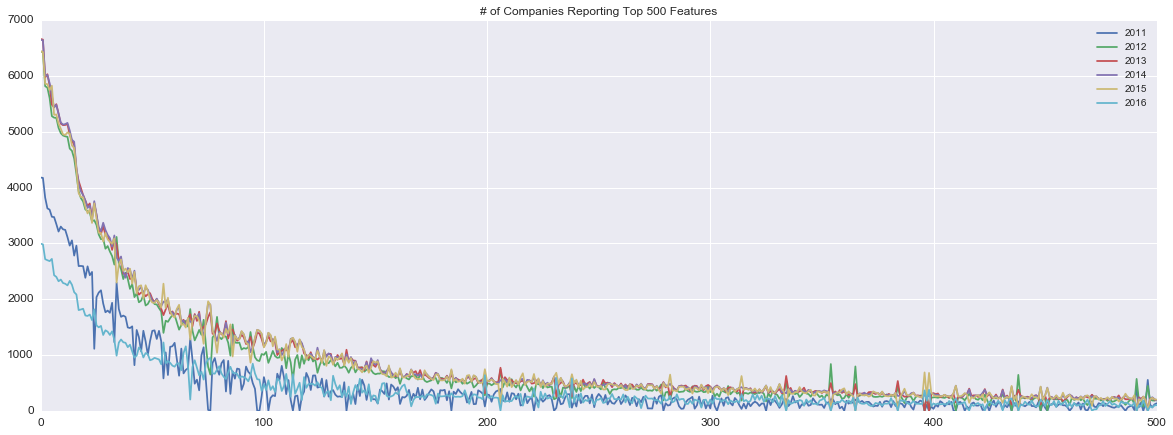

In [404]:
#First drop the unnecessary year
reducedLabels = allLabels.drop(['2010'], axis=1, inplace=False)

#Plot total by feature, we divide by 4 because the totals are summed up quarterly and this allows us to get an
#estimate of number of companies since each company reports 4 times per year.
for c in range(2, 8):
    reducedLabels.ix[:500, c].divide(4).plot(legend=True, figsize=(20, 7), title='# of Companies Reporting Top 500 Features', fontsize=12)

Looking at the graph above, we can see that the number of companies reporting a particular feature is not constant.  This is expected as most companies will report the major line items of the income statement but may not to do so with some other subset.  To keep a decent sample, we can keep the cutoff at the top 50 features, which gives us with approximately 1000 companies (most likely the largest 1000 companies).

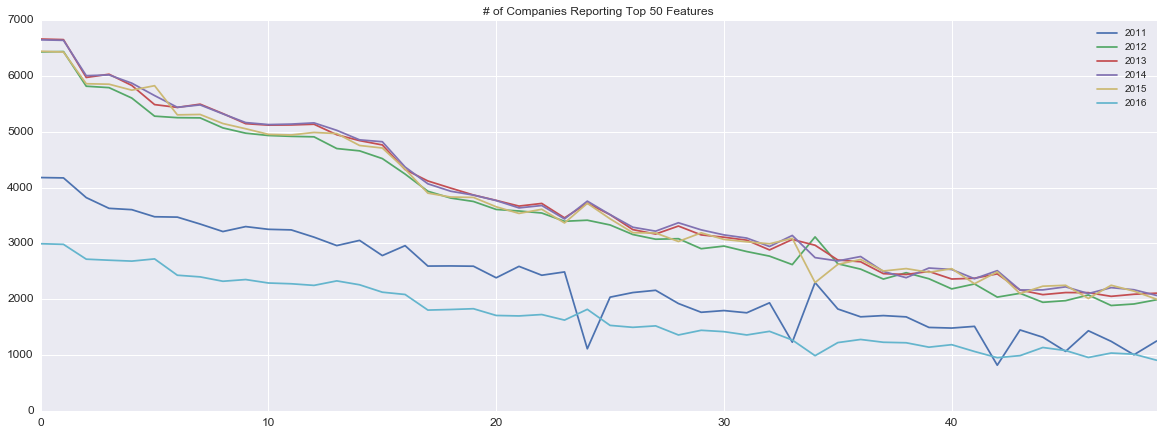

In [814]:
#We can now drop everything except the top 50 features and recreate the plot:
reducedLabels.drop(reducedLabels.ix[50:].index, axis=0, inplace=True)
for c in range(2, 8):
    reducedLabels.ix[:, c].divide(4).plot(legend=True, figsize=(20, 7), title='# of Companies Reporting Top 50 Features', fontsize=12)

Now we are ready to explore the data a little further.  So far we have dropped 2010 from the analysis and restricted the data to the Top 50 most reported features.  If each company reports each line item only once per quarter, then our sample should include atleast 1000 companies.  The next step is to create a final feature list and import the relevant feature data for all companies.  Note that we have not been through the feature list or apply any domain knowledge so far.

In [815]:
finalFeatures = reducedLabels.ix[:, 0]
display(pd.DataFrame(finalFeatures))

,Indicator ID
0,LiabilitiesAndStockholdersEquity
1,Assets
2,CashAndCashEquivalentsAtCarryingValue
3,StockholdersEquity
4,NetIncomeLoss
5,RetainedEarningsAccumulatedDeficit
6,CommonStockValue
7,CommonStockSharesAuthorized
8,CommonStockSharesIssued
9,PropertyPlantAndEquipmentNet


We will now retrieve the data for the final feature list for all available companies and explore further; the goal is to filter our the companies that are not reporting consistently.

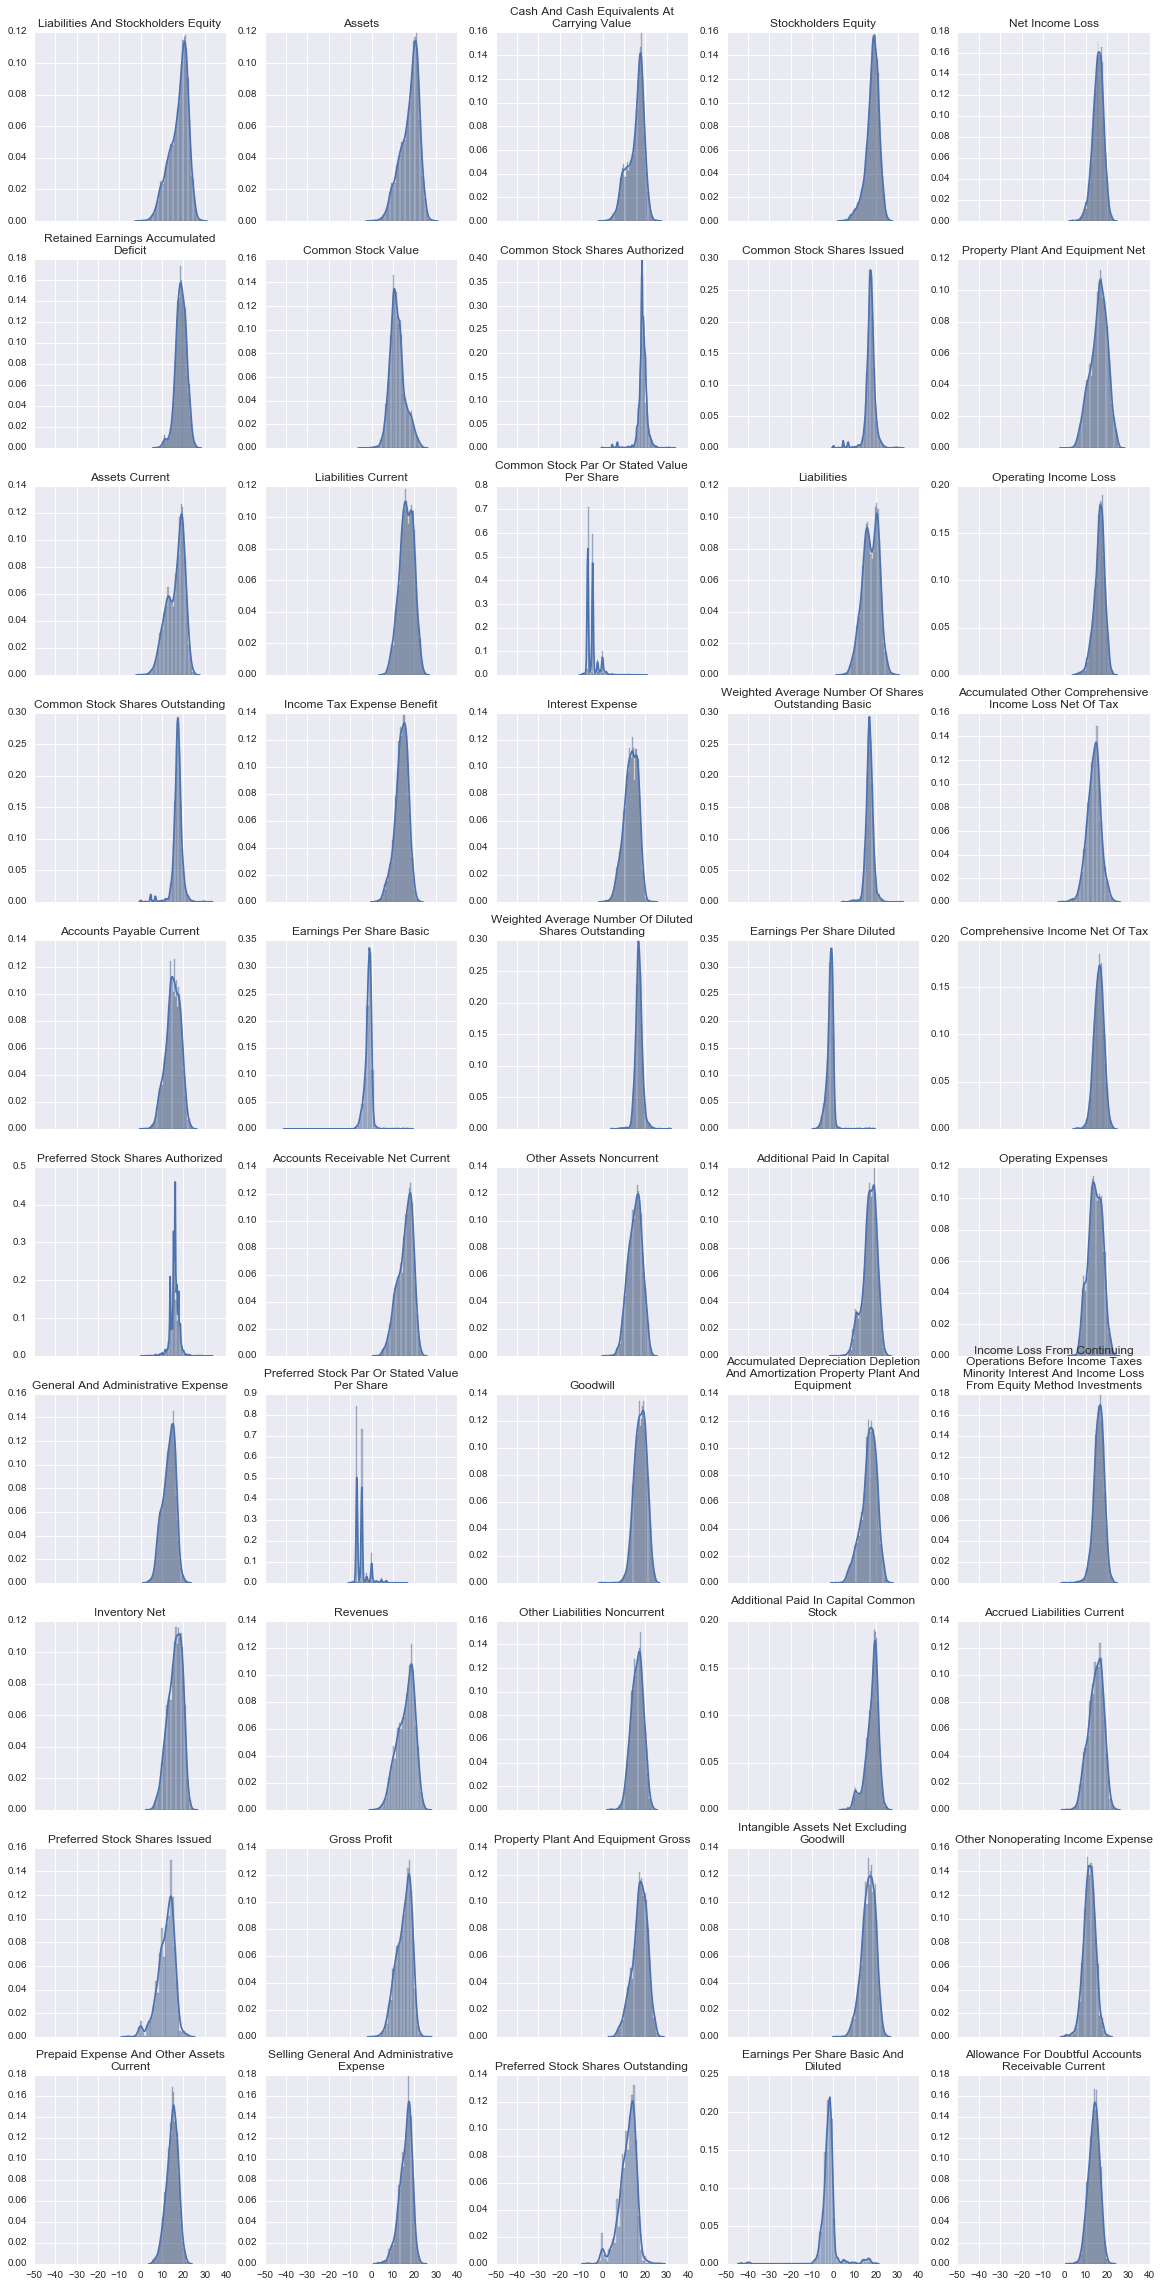

In [976]:
#Import top 50 feature data for all companies.  We download separately since server kept crashing.
if globalUpdate:
    companyData = {}
    for c in range(len(finalFeatures)):
        eachFeature = finalFeatures[c]
        print('Importing ' + str(c) + ' of 50.')
        tempdata = getIndicatorByCategory(inputCategory=eachFeature)
        companyData[eachFeature] = tempdata.iloc[:, 2:]
        companyData[eachFeature].index = tempdata.iloc[:, 0].values
        clear_output(wait=True)

fig, axes = plt.subplots(10, 5, figsize=(20,40), sharex=True)
for d in range(10):
    for c in range(5):
        #We take the average of each company over time to get a sense of the distribution for all companies.
        #tempdata = pd.lreshape(companyData[finalFeatures[d*5+c]],{finalFeatures[d*5+c]:companyData[finalFeatures[d*5+c]].iloc[:, 2:].columns.values})[finalFeatures[d*5+c]]
        
        #Drop the missing values and plot the log t
        sns.distplot(np.log(companyData[finalFeatures[d*5+c]].iloc[:, 1:].mean(axis=1)).replace([np.inf, -np.inf], np.nan).dropna(), ax=axes[d, c])
        axes[d, c].set(title="\n".join(wrap(formatIndicatorString(finalFeatures[d*5+c]), 35)))
#display(np.log(companyData['OperatingExpenses'].mean(axis=1)).dropna().sum())
#sns.distplot(np.log(companyData['AccountsReceivableNetCurrent'].mean(axis=1)).dropna(), color="b")#.plot(kind='kde')
#companyData['Goodwill'].mean(axis=1).plot(kind='kde')

At first glance, some of the features look like bi-modal distributions.  We will now proceed to transform the data and digging in to the sample in more detail.  We begin with dropping 2010 from the sample, storing the data with the company identifiers as the index, and detecting outliers.  For outliers, we are not going to remove just extreme values, but rather companies that appear to be reporting extreme value systemically, across most features.  This is because we do not want to remove extremely low values that may be indicate companies close to bankruptcy as they can provide valuable information for our analysis.

In [997]:
tester = pd.melt(companyData[finalFeatures[0]].ix[companies.index], value_name=finalFeatures[0]).iloc[:, 1:]
print(np.shape(tester)[0]/np.shape(companies.index.values)[0])
dateRange = pd.date_range(str(3*int(companyData[finalFeatures[0]].columns[1][-1])) + '/1/' + companyData[finalFeatures[0]].columns[2][:4], periods=len(companyData[finalFeatures[0]].columns)-2, freq='Q')
testerind = pd.MultiIndex.from_product([companies.index.values, dateRange.values])
tester.index = testerind


display(tester.tail())
display(companies.tail())
#display(companyData[finalFeatures[0]].ix[companies.index].tail())
#list(companyData[finalFeatures[0]].columns)

23


ValueError: Length mismatch: Expected axis has 280209 elements, new values have 255843 elements

In [907]:
#Transform the data and identify some outliers:
logCompanyData = {}
dateRange = pd.date_range(str(3*int(companyData[finalFeatures[0]].columns[2][-1])) + '/1/' + companyData[finalFeatures[0]].columns[2][:4], periods=len(companyData[finalFeatures[0]].columns)-2, freq='Q')
outlierData = pd.DataFrame()
reportingData = pd.DataFrame()
for c in range(50):#range(len(finalFeatures)):
    tempData = np.log(companyData[finalFeatures[c]].iloc[:,3:]).replace([np.inf, -np.inf], np.nan)
    tempData.index = companyData[finalFeatures[c]].iloc[:, 0]
    logCompanyData[finalFeatures[c]] = tempData
    Q1 = np.nanpercentile(tempData, 25)
    Q3 = np.nanpercentile(tempData, 75)
    step = 1.5 * (Q3 - Q1)
    outliers = tempData.lt(Q1-step) | tempData.gt(Q3+step)
    #Record all outlies as well as non-null values that will be used later
    reporting = outliers.notnull().sum(axis=1)
    outliers = outliers.sum(axis=1)
    #Add to existing dataframes
    outlierData = pd.concat([outlierData, pd.DataFrame(outliers, columns=[finalFeatures[c]])], axis=1, join='outer')
    reportingData = pd.concat([reportingData, pd.DataFrame(reporting, columns=[finalFeatures[c]])], axis=1, join='outer')

#Now we find out what proportion of reported statistics were in fact outliers for a specific company.  The goal
#is to find companies that are reporting outliers frequently, indicating incorrect or skewed reporting.  We don't
#want to just exluded extreme values as companies going bankrupt will tend to have outliers but are actually and
#important part of the sample.
outlierRatio = outlierData.divide(reportingData)
#Now we isolate by companies with 50% of time periods reported as outliers
potentialOutliers = outlierRatio.ge(0.5).sum(axis=1)
#Divide by total reported features to determine how may of the reported features have been outliers for more than
#50% of the time periods reported.
potentialOutliers = potentialOutliers.divide(outlierRatio.notnull().sum(axis=1))
#See a description of all of them greater than 0
display(pd.DataFrame(potentialOutliers[potentialOutliers.gt(0)].describe(np.arange(0.1, 1, 0.1)), columns=['Outier Ratio']))
#We will now drop companies reporting outliers for 1/3 of the features.
potentialOutliers = potentialOutliers[potentialOutliers.ge(0.5)].index
display(companies.loc[potentialOutliers])
display(logCompanyData['Assets'].head())
#[potentialOutliers.index[potentialOutliers.gt(0.2)]]

,Outier Ratio
count,1162.000000
mean,0.057038
std,0.045087
min,0.021277
10%,0.025000
20%,0.027027
30.0%,0.031250
40%,0.035714
50%,0.040000
60%,0.050000


,name_latest,names_previous
company_id,,
1038286,Golden State Petroleum Transport Corp,NaN


,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,...,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2
company_id,,,,,,,,,,,,,,,,,,,,,
1000045,NaN,19.336573,19.346392,26.264043,19.365505,19.382459,19.395702,19.389431,19.390836,19.414275,...,19.462474,19.489811,19.505110,19.507558,19.527686,19.559511,19.587967,19.597754,19.600286,19.611316
1000180,22.910224,22.973273,23.011843,23.043165,23.027061,23.033397,23.057496,23.059201,23.062804,22.987006,...,23.082833,23.096281,23.094281,23.054434,22.970467,22.936958,22.928569,NaN,22.975805,NaN
1000228,22.290838,22.309181,22.291527,NaN,22.283436,22.299200,22.354765,22.397367,22.373017,22.365075,...,22.494841,22.513650,22.536564,22.537896,22.504851,22.532476,22.575110,22.595797,22.610422,NaN
1000229,20.207887,20.129481,20.148614,20.220969,20.230080,20.249532,20.274682,20.271520,20.300822,20.300323,...,20.338137,20.350938,20.345122,20.331190,20.261243,20.306211,20.269301,20.253675,20.190961,20.164835
1000230,NaN,17.607469,NaN,17.599245,17.666075,17.707492,17.681748,17.650189,17.682427,17.684962,...,17.676886,17.672291,17.728306,17.644798,17.693280,17.708002,17.622813,17.556975,17.557805,NaN


In [932]:
dateRange = pd.date_range(str(3*int(companyData[finalFeatures[0]].columns[2][-1])) + '/1/' + companyData[finalFeatures[0]].columns[2][:4], periods=len(companyData[finalFeatures[0]].columns)-2, freq='Q')
tester = pd.MultiIndex.from_product([dateRange.values, finalFeatures], names=['Date', 'Company ID'])
print(tester)

MultiIndex(levels=[[2010-12-31 00:00:00, 2011-03-31 00:00:00, 2011-06-30 00:00:00, 2011-09-30 00:00:00, 2011-12-31 00:00:00, 2012-03-31 00:00:00, 2012-06-30 00:00:00, 2012-09-30 00:00:00, 2012-12-31 00:00:00, 2013-03-31 00:00:00, 2013-06-30 00:00:00, 2013-09-30 00:00:00, 2013-12-31 00:00:00, 2014-03-31 00:00:00, 2014-06-30 00:00:00, 2014-09-30 00:00:00, 2014-12-31 00:00:00, 2015-03-31 00:00:00, 2015-06-30 00:00:00, 2015-09-30 00:00:00, 2015-12-31 00:00:00, 2016-03-31 00:00:00, 2016-06-30 00:00:00], [u'AccountsPayableCurrent', u'AccountsReceivableNetCurrent', u'AccruedLiabilitiesCurrent', u'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment', u'AccumulatedOtherComprehensiveIncomeLossNetOfTax', u'AdditionalPaidInCapital', u'AdditionalPaidInCapitalCommonStock', u'AllowanceForDoubtfulAccountsReceivableCurrent', u'Assets', u'AssetsCurrent', u'CashAndCashEquivalentsAtCarryingValue', u'CommonStockParOrStatedValuePerShare', u'CommonStockSharesAuthorized', u'CommonStockSha

In [939]:
logCompanyData[finalFeatures[0]].ix[companies.index]

,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,...,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2
1000045,NaN,19.336573,19.346392,26.264043,19.365505,19.382459,19.395702,19.389431,19.390836,19.414275,...,19.462474,19.489811,19.505110,19.507558,19.527686,19.559511,19.587967,19.597754,19.600286,19.611316
1000180,22.910224,22.973273,23.011843,23.043165,23.027061,23.033397,23.057496,23.059201,23.062804,22.987006,...,23.082833,23.096281,23.094281,23.054434,22.970467,22.936958,22.928569,NaN,22.975805,NaN
1000209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000228,22.290838,22.309181,22.291527,NaN,22.283436,22.299200,22.354765,22.397367,22.373017,22.365075,...,22.494841,22.513650,22.536564,22.537896,22.504851,22.532476,22.575110,22.595797,22.610422,NaN
1000229,20.207887,20.129481,20.148614,20.220969,20.230080,20.249532,20.274682,20.271520,20.300822,20.300323,...,20.338137,20.350938,20.345122,20.331190,20.261243,20.306211,20.269301,20.253675,20.190961,20.164835
1000230,NaN,17.607469,NaN,17.599245,17.666075,17.707492,17.681748,17.650189,17.682427,17.684962,...,17.676886,17.672291,17.728306,17.644798,17.693280,17.708002,17.622813,17.556975,17.557805,NaN
1000232,NaN,20.289648,20.267129,NaN,20.333322,20.323598,20.326417,20.368033,20.376704,20.379585,...,20.478201,20.481571,20.492750,20.566857,20.568389,20.564216,20.654497,20.697624,20.714058,20.717316
1000278,NaN,15.101816,14.815190,NaN,14.715308,14.773738,14.504749,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000298,NaN,22.482396,22.445469,NaN,22.467932,22.450139,22.509523,22.512787,22.522376,22.501952,...,22.455235,22.467231,22.456832,22.442199,22.507777,22.467991,22.445118,22.374098,22.391864,22.396037
1000459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [703]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit

,2010Q4,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,...,2014Q1,2014Q2,2014Q3,2014Q4,2015Q1,2015Q2,2015Q3,2015Q4,2016Q1,2016Q2
company_id,,,,,,,,,,,,,,,,,,,,,
1000045,NaN,NaN,2.499004e+08,2.523663e+08,2.548759e+11,2.572360e+08,2.616345e+08,2.651224e+08,2.634651e+08,2.638355e+08,...,2.834296e+08,2.912846e+08,2.957751e+08,2.965002e+08,3.025286e+08,3.123114e+08,3.213261e+08,3.244864e+08,3.253090e+08,3.289170e+08
1000180,NaN,8.908073e+09,9.487807e+09,9.860895e+09,1.017465e+10,1.001211e+10,1.007575e+10,1.032151e+10,1.033913e+10,1.037644e+10,...,1.058637e+10,1.072970e+10,1.070826e+10,1.028996e+10,9.461221e+09,9.149431e+09,9.073003e+09,NaN,9.511856e+09,NaN
1000228,NaN,4.794994e+09,4.883759e+09,4.798296e+09,NaN,4.759633e+09,4.835256e+09,5.111532e+09,5.333997e+09,5.205686e+09,...,5.880110e+09,5.991754e+09,6.130631e+09,6.138807e+09,5.939264e+09,6.105626e+09,6.371558e+09,6.504740e+09,6.600570e+09,NaN
1000229,NaN,5.972740e+08,5.522330e+08,5.629010e+08,6.051390e+08,6.106780e+08,6.226730e+08,6.385320e+08,6.365160e+08,6.554430e+08,...,6.803630e+08,6.891280e+08,6.851320e+08,6.756530e+08,6.300080e+08,6.589850e+08,6.351050e+08,6.252580e+08,5.872500e+08,5.721060e+08
1000230,NaN,NaN,4.434315e+07,NaN,4.397997e+07,4.701960e+07,4.900788e+07,4.776234e+07,4.627855e+07,4.779479e+07,...,4.753067e+07,4.731280e+07,5.003861e+07,4.602974e+07,4.831634e+07,4.903292e+07,4.502882e+07,4.215968e+07,4.219469e+07,NaN
1000232,NaN,NaN,6.481600e+08,6.337270e+08,NaN,6.770950e+08,6.705430e+08,6.724360e+08,7.010103e+08,7.071150e+08,...,7.826540e+08,7.852960e+08,7.941240e+08,8.552091e+08,8.565210e+08,8.529540e+08,9.335420e+08,9.746840e+08,9.908340e+08,9.940680e+08
1000278,NaN,NaN,3.619388e+06,2.717410e+06,NaN,2.459105e+06,2.607072e+06,1.992198e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000298,NaN,NaN,5.807386e+09,5.596845e+09,NaN,5.723992e+09,5.623042e+09,5.967074e+09,5.986588e+09,6.044264e+09,...,5.651770e+09,5.719980e+09,5.660808e+09,5.578572e+09,5.956668e+09,5.724326e+09,5.594883e+09,5.211317e+09,5.304724e+09,5.326907e+09
1000459,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The fundamentals database, unfortunately, does not contain historical prices and also does not have trading tickers that we can use to find historical prices from other sources.  As a result, we need to define some functions that we can use to query the SEC public filings to complete the database.

In [216]:
import xml.etree.ElementTree
import urllib2


def getIssuerInfoFromEdgar(inputTickerCIK):
    #This function uses the latest Form 4 filing on Edgar for a specific ticker or CIK to retrieve issuer info.
    try:
        #Search for the company's top 10 Form 4 filings
        tempfile = urllib2.urlopen('https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=' + inputTickerCIK + '&count=10&type=4&owner=only&output=xml').read()
        #Locate the most recent one
        data = xml.etree.ElementTree.fromstring(tempfile)
        #Open the complete text submission using the file number
        tempfile = urllib2.urlopen(data[1][0][1].text[:data[1][0][1].text.find('-index.htm')] + '.txt').read()
        #Populate a dictionary with all the necessary information.
        if tempfile.find('<issuer>')==-1 | tempfile.find('</issuer>')==-1:
            return None
        else:
            results = {}
            results['ISSUER_CIK'] = (tempfile[tempfile.find('<issuerCik>')+11:tempfile.find('</issuerCik>')])
            results['ISSUER_NAME'] = (tempfile[tempfile.find('<issuerName>')+12:tempfile.find('</issuerName>')])
            results['ISSUER_TICKER'] = (tempfile[tempfile.find('<issuerTradingSymbol>')+21:tempfile.find('</issuerTradingSymbol>')])
            return results
    except:
        return None

def getIssuerInfoForList(inputTickerList):
    #Use this function to get informaiton on a list of tickers.  Returns an array of dictionarys
    results = []
    for eachTicker in inputTickerList:
        results.append(getIssuerInfoFromEdgar(eachTicker))
    return results
    
def getCIKFromTicker(inputTicker):
    #We use the following funciton to retrieve the CIK number for a specific ticker by querying EDGAR.
    #The CIK number is used to link the historical prices with the XBRL database hosted at usfundamentals.com.
    try:
        file = urllib2.urlopen('https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=' + inputTicker + '&count=10&output=xml').read()
        data = xml.etree.ElementTree.fromstring(file)
        return data[0][0].text
    except:
        return None

#Use the following for getting multiple tickers
def getCIKFromTickerList(inputTickers):
    outputCIK = []
    for eachTicker in inputTickers:
        outputCIK.append(getCIKFromTicker(eachTicker))
    return outputCIK

#Test the connection, by querying for Micosoft (MSFT), we should get 0000789019:
print('CIK for MSFT is ' + str(getCIKFromTicker('MSFT')) + '.')

#Test group with an incorrect ticker:
test_tickers = ['AAPL', 'NON_EXISTENT_TICKER', 'XOM', '0000789019', 'GOOG', '0001412270']
test_cik = getIssuerInfoForList(test_tickers)
for c in range(len(test_tickers)):
    print('INFO for ' + test_tickers[c] + ' is ' + str(test_cik[c]) + '.')


CIK for MSFT is 0000789019.
INFO for AAPL is {'ISSUER_TICKER': 'AAPL', 'ISSUER_CIK': '0000320193', 'ISSUER_NAME': 'APPLE INC'}.
INFO for NON_EXISTENT_TICKER is None.
INFO for XOM is {'ISSUER_TICKER': 'XOM', 'ISSUER_CIK': '0000034088', 'ISSUER_NAME': 'EXXON MOBIL CORP'}.
INFO for 0000789019 is {'ISSUER_TICKER': 'MSFT', 'ISSUER_CIK': '0000789019', 'ISSUER_NAME': 'MICROSOFT CORP'}.
INFO for GOOG is {'ISSUER_TICKER': 'GOOG', 'ISSUER_CIK': '0001652044', 'ISSUER_NAME': 'Alphabet Inc.'}.
INFO for 0001412270 is {'ISSUER_TICKER': 'CRCM', 'ISSUER_CIK': '0001412270', 'ISSUER_NAME': 'Care.com Inc'}.


In [722]:
getIssuerInfoFromEdgar('0001062506')

{'ISSUER_CIK': '0001062506',
 'ISSUER_NAME': 'ATLANTICA INC',
 'ISSUER_TICKER': 'ATTC.OB'}